In [1]:
from utils_project import *

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

def wordcloud_black(word, font_size, position, orientation, random_state=None, **kwargs):
    # set the wordcloud background color to white
    # set max_words to 1000
    # set width and height to higher quality, 3000 x 2000
    return("hsl(0,100%, 1%)")

def plot_wordcloud(wordcloud, ax=None):
    if ax is None: fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    wordcloud.recolor(color_func=wordcloud_black)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

def get_my_pos(word):
    # specify the pos for words in this datatset
    to_check = {'felt': 'v'}
    return to_check.get(word, None)

def get_nltk_pos(word_list):
    """Map nltk POS tags to wordnet POS tags for a word list."""
    mapping = {'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV, 'J': wordnet.ADJ}
    pos_tagged = nltk.pos_tag(word_list)
    return [mapping.get(pos[1][0], wordnet.NOUN) for pos in pos_tagged]

def lemmatize_text(word, pos=None):

    # check if the word is in the exceptions dictionary for the given POS; otherwise, lemmatize the word normally
    # https://stackoverflow.com/questions/33594721/why-nltk-lemmatization-has-wrong-output-even-if-verb-exc-has-added-right-value

    # POS tag the word if not provided
    if pos is None: 
        pos = get_my_pos(word) or get_nltk_pos([word])[0]

    # check the morphy exceptions
    exceptions = wordnet._exception_map[pos]
    if word in exceptions:
        lemmatized = exceptions[word][0]
    else:
        # wordnet
        lemmatizer = WordNetLemmatizer()
        lemmatized = lemmatizer.lemmatize(word, pos)

    # # do they match?
    # if (verbose) & (lemmative_morphy != lemmatize_wn):
    #     print(f"Mismatch - Morphy: {lemmative_morphy}, WordNet: {lemmatize_wn}")

    return lemmatized

def infrequent_filter(words, min_freq=2):
    # remove words that appear less than min_freq times
    word_freq = Counter(words)
    return [word for word in words if word_freq[word] >= min_freq]

def stopwords_filter(words):
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    return [word for word in words if word not in stop_words]

def preprocess_text(text, remove_stopwords=True, min_freq=2):

    # remove punctuation & tokenize
    text = text.lower().translate(str.maketrans('', '', string.punctuation))
    word_tokens = word_tokenize(text)

    # remove words
    preprocessed_text = stopwords_filter(word_tokens) if remove_stopwords else word_tokens
    preprocessed_text = infrequent_filter(preprocessed_text) if (min_freq > 1) else preprocessed_text

    # lemmatize (e.g. running -> run)
    preprocessed_text = [lemmatize_text(word) for word in preprocessed_text] 

    return " ".join(preprocessed_text)

def mask_value(x, value=0.33):
    return x > value

def mask_ptile(x, ptile=90):
    # mask as a percentile of loadings
    return x > np.percentile(x, ptile)

def mask_top_items(x, n_items=20):
    return np.arange(len(x)) < n_items

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def color_converter(colors):
    """ converts a list of colors to a dataframe with color name, hex, and RGB values
        input: list of colors
        output: dataframe with color name, hex, and RGB values
    """
    converted_colors = []
    for color in colors:
        # check if it's a string color name
        if isinstance(color, str) and color in mcolors.CSS4_COLORS:
            rgb = mcolors.CSS4_COLORS[color]
            rgb_normalized = mcolors.hex2color(rgb)  # normalized RGB
            converted_colors.append((color, rgb, rgb_normalized))
        # check if it's a hex color
        elif isinstance(color, str) and color.startswith('#'):
            color_name = None  # cannot reverse lookup color name from hex
            rgb_normalized = mcolors.hex2color(color)
            converted_colors.append((color_name, color, rgb_normalized))
        # check if it's a rgb color
        elif isinstance(color, tuple) and len(color) == 3:
            color_name = None  # cannot reverse lookup color name from RGB
            rgb = mcolors.rgb2hex(color)
            converted_colors.append((color_name, rgb, color))
        else:
            print(f"Invalid color {color}")
    return pd.DataFrame(converted_colors, columns=['color_name', 'hex', 'rgb'])

def reorder_corrmat_and_loadings(corrmat, loadings, ques_order=None):

    # find the indices of the items that belong to each questionnaire
    if ques_order is None:
        ques_order = ['apdis', 'lsas', 'bapq', 'sds', 'aes', 'bpd', 'sss', 'oci']
    ques_order_ixs = [np.where([qo in i for i in corrmat.columns])[0] for qo in ques_order]

    # reorder correlation matrix & loadings so that the items are grouped by questionnaire
    corrmat_  = corrmat.iloc[np.concatenate(ques_order_ixs), np.concatenate(ques_order_ixs)]
    loadings_ = loadings[np.concatenate(ques_order_ixs), :]
    return corrmat_, loadings_

def get_item_colors_and_labels(items):

    # get colors for items etc..
    colors = ['red', 'blue', 'pink', 'green', 'lavender', 'grey', 'fuchsia', 'orange', 'dodgerblue', 
              'yellow', 'orchid', 'indigo', 'aqua', 'palegreen', 'silver', 'plum', 'fuchsia', 'coral',
              'gold', 'pink','slategray', 'forestgreen', 'peachpuff', 'honeydew', 'brown', 'olivedrab',
                'darkturquoise', 'tan', 'springgreen', 'mintcream', 'navajowhite', 'chocolate', 'lightblue', 'chartreuse',
                'lime', 'yellowgreen', 'khaki', 'gold', 'teal', 'tomato']

    ques_order    = np.array(list(dict.fromkeys([i.split('_')[0] for i in items])))
    legend_labels = [ques_labels[q] for q in ques_order]

    # for each itme, find which ques_order it matches and assign it the corresponding color
    item_colors = []
    for it in items:
        item_colors.extend(colors[np.where(ques_order == qo)[0][0]] for qo in ques_order if qo in it)
    item_colors = list(color_converter(item_colors)['rgb'].values)
    return dict(zip(items, item_colors)), dict(zip(legend_labels, colors))

def plot_corrmat(corrmat, cmap='RdBu_r', ax=None):
    if ax is None: fig, ax = plt.subplots(1,1, figsize=(5,5))
    sns.heatmap(corrmat, vmin=-1, vmax=1,
                xticklabels=False, yticklabels=False,
                cmap=cmap, cbar=False, 
                ax=ax)
    ax.axhline(y=0, color='k',linewidth=2)
    ax.axhline(y=corrmat.shape[1], color='k',linewidth=2)
    ax.axvline(x=0, color='k',linewidth=2)
    ax.axvline(x=corrmat.shape[0], color='k',linewidth=2)
    return ax

def plot_loadings_on_ax(loadings, item_colors=None, ax=None, 
                        orient='v', which_side='left', adjust=0.025):

    if item_colors is None: 
        item_colors = ['gray'] * loadings.shape[0]
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 3))

    sns.barplot(x=np.arange(len(loadings)), y=loadings, 
                palette=item_colors, edgecolor='black', linewidth=0.75,
                orient=orient, 
                ax=ax)
    ax.set_yticks([])
    ax.set_xticks([])
    pos = ax.get_position()
    if which_side == 'top':
        ax.set_position([pos.x0, pos.y0+adjust, pos.width, pos.height])
    elif which_side == 'bottom':
        ax.set_position([pos.x0, pos.y0-adjust, pos.width, pos.height])
    elif which_side == 'left':
        ax.invert_xaxis()
        ax.set_position([pos.x0-adjust, pos.y0, pos.width, pos.height])
    elif which_side == 'right':
        ax.set_position([pos.x0+adjust, pos.y0, pos.width, pos.height])
    return ax

def prefix_indices(strings, prefixes):
    indices = []
    for i, s in enumerate(strings):
        prefix = s.split("_")[0]
        if prefix in prefixes:
            indices.append(i)
    return indices

Initial n=579
Validation n=255
Combined n=834
Questionnaire items loaded


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/matty_gee/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/matty_gee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/matty_gee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/matty_gee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/matty_gee/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<h1 align="center"> Exploratory Factor Analysis </h1>

In [13]:
#--------------------------------------------------------------------------------------------------------------------
# load data
#--------------------------------------------------------------------------------------------------------------------

print('LOADING DATA')
print('-------------------------------')

# initial sample
init_df  = sample_dict['Initial']['data']
init_dir = f'{base_dir}/data/Initial_2021/Summary'
val_df   = sample_dict['Validation']['data']
val_dir  = f'{base_dir}/data/Replication_2022/Summary/'

# sample sizes
print(f'Initial    n={init_df.shape[0]}')
print(f'Validation n={val_df.shape[0]}')
print(f'Combined   n={val_df.shape[0] + init_df.shape[0]}')

# get questionnaire data & correlation matrices
init_ques_df = subset_df(init_df, fa_prefixes)
val_ques_df  = subset_df(val_df, fa_prefixes)
init_corrmat = init_ques_df.iloc[:,1:].corr()
val_corrmat  = val_ques_df.iloc[:,1:].corr()

# init_corrmat_r = pd.read_csv(f'{init_dir}/Individual_summaries/Questionnaire_hetcor_n636.csv') # corr mat for factor analyis
# init_corrmat_r.set_index('Unnamed: 0', inplace=True)
# val_corrmat_r = pd.read_csv(f'{val_dir}/Individual_summaries/Questionnaire_hetcor_n276.csv')
# val_corrmat_r.set_index('Unnamed: 0', inplace=True)
# init_corrmat_r = init_corrmat_r.loc[init_ques_df.columns[1:], init_ques_df.columns[1:]]
# val_corrmat_r  = val_corrmat_r.loc[val_ques_df.columns[1:], val_ques_df.columns[1:]]

assert np.all(init_ques_df.columns[1:] == val_ques_df.columns[1:]), \
    'initial & validation questionnaire dataframes are disordered'
assert np.all(init_corrmat.columns == init_ques_df.columns[1:]), \
    'initial corr mat & questionnaire dataframe are disordered'
assert np.all(val_corrmat.columns == val_ques_df.columns[1:]), \
    'validation corr mat & questionnaire dataframe are disordered'

LOADING DATA
-------------------------------
Initial    n=579
Validation n=255
Combined   n=834


## 0 - Characterize questionnaire space

In [ ]:
# items       = init_corrmat.columns
# social_ixs  = prefix_indices(items, ['bapq', 'lsas', 'apdis'])
# mood_ixs    = prefix_indices(items, ['sds', 'aes'])
# fig, ax = plot_factor_analysis_corrmat(init_corrmat)
# for ixs in [social_ixs, mood_ixs]:
#     ax.add_patch(Rectangle((ixs[0]-.75, ixs[0]-.75), len(ixs), len(ixs), 
#                            fill=False, facecolor='black', edgecolor='black', lw=3))
# plt.show()
# save_figure(fig, f'{fig_dir}/EFA_corrmat_chunks')

# fig, ax = plot_factor_analysis_corrmat(init_corrmat)
# save_figure(fig, 'EFA_corrmat', fig_dir=fig_dir)

# fig, axs = plot_factor_analysis_corrmat(init_corrmat, loadings=None, 
#                                         labels=None, outline_ques=True)
# save_figure(fig, 'EFA_corrmat_outlined', fig_dir=fig_dir)

# df = sample_dict['Combined']
# ques_df = subset_df(df, fa_prefixes)
# ques_df.iloc[:,1:].describe()
# for init_cm, repl_cm in [[init_corrmat_r, repl_corrmat_r], [init_corrmat, repl_corrmat]]:
#     fig, axs = plt.subplots(1,2, figsize=(16, 7))
#     sns.heatmap(init_cm, ax=axs[0], cmap='coolwarm', vmin=-1, vmax=1)
#     axs[0].set_aspect("equal")
#     axs[0].set_title('Initial sample', fontsize=20)
#     axs[0].collections[0].colorbar.remove()
#     sns.heatmap(repl_cm, ax=axs[1], cmap='coolwarm', vmin=-1, vmax=1)
#     axs[1].set_aspect("equal")
#     axs[1].set_title('Replication sample', fontsize=20)
#     axs[1].collections[0].colorbar.remove()
#     plt.show()

## 1 - Run PCA to find optimal number of factors [initial sample only]

In [4]:
def plot_eigenvalues(eigvalues, top=15):
    fig, ax = plt.subplots(figsize=(5, 5))
    barlist = plt.bar(np.arange(0, top), eigvalues[:top], width=1.0, facecolor='blue', edgecolor='black')
    plt.ylabel('Eigenvalue', fontsize=label_fontsize)
    plt.xlabel('Factor number', fontsize=label_fontsize)
    plt.xticks(np.arange(0, 15), ['','','3','','','6','','','9','','','12','','','15'], fontsize=tick_fontsize)
    return fig, ax, barlist

# fig, ax, barlist = plot_eigenvalues(pca.eigvals)
# save_figure(fig, f'{fig_dir}/EFA-eigenvalues')

# fig, ax, barlist = plot_eigenvalues(pca.eigvals)
# for f in range(3):  
#     barlist[f].set_facecolor('orange')
# plt.show()
# save_figure(fig, f'{fig_dir}/EFA-eigenvalues_CNG-test')

# # # eigenvalues is variance explained by each component
# # print('top 5 eigenvalues:')
# # print(pca.eigvals[:5])

## 2 - Run factor analysis

In [14]:
#--------------------------------------------------------------------------------------------------------------------
# run factor analyses
#--------------------------------------------------------------------------------------------------------------------

print('\nRUNNING EFA')
print('-------------------------------')

n_comps = 3 
loading_threshs = [25, 50, 75]
rotations = ['quartimax']

for rotation, loading_thresh in itertools.product(rotations, loading_threshs):
    
    #------------------------------------------------------
    # run full factor analysis
    #------------------------------------------------------

    print(f'Running full EFA with {n_comps} components and {rotation} rotation\n')

    # fit to & transform initial sample, transform validation sample
    fa, f_labels, f_summary = run_fa(init_ques_df, init_corrmat, n_comps, rotation)
    init_df[f_labels] = fa.X_reduced
    val_df[f_labels]  = fa.transform(val_ques_df.iloc[:,1:].values)

    # pickle the fa dictionary
    fa_dict = fa.output()
    fa_dict['factor_labels'] = f_summary
    pickle_file(fa_dict, f'{base_dir}/factor_analyses/fa_{rotation}.pkl')

    #------------------------------------------------------
    # run reduced factor analysis
    #------------------------------------------------------

    print(f'\nRunning reduced FA with {loading_thresh}% threshold\n')

    # get efa's best items (largest loadings above some percentile threshold)
    min_items = flatten_lists(fa.efa_partial(thresh=loading_thresh, plot=False))
    min_items.sort()
    init_ques_df_min, init_corrmat_min = init_ques_df.loc[:, min_items], init_corrmat.loc[min_items, min_items]
    assert np.all(init_corrmat_min.columns == init_ques_df_min.columns), \
        'initial reduced corr. matrix & questionnaire dataframe are disordered'

    # fit to & transform initial sample
    init_fa_min, init_f_labels, f_summary = run_fa(init_ques_df_min, init_corrmat_min, n_comps, rotation)
    init_df[[f'{f}_thresh{loading_thresh}' for f in init_f_labels]] = init_fa_min.X_reduced
    
    # pickle the fa dictionary
    fa_dict = init_fa_min.output()
    fa_dict['factor_labels'] = f_summary
    pickle_file(fa_dict, f'{base_dir}/factor_analyses/fa_{rotation}_{loading_thresh}.pkl')

    # transform validation sample 
    val_ques_df_min, val_corrmat_min = val_ques_df.loc[:, min_items], val_corrmat.loc[min_items, min_items]
    assert np.all(val_corrmat_min.columns == val_ques_df_min.columns), \
        'validation reduced corr. matrix & questionnaire dataframe are disordered'
    val_df[[f'{l}_thresh{loading_thresh}' for l in init_f_labels]] = init_fa_min.transform(val_ques_df_min)

    # #------------------------------------------------------
    # # are reduced FA loadings stable across samples?
    # #------------------------------------------------------

    # # test if fator scores are consistent within initial sample across full and reduced factor analyses
    # print('\nTesting consistency of factor scores within Initial sample:')
    # for f in f_labels:
    #     r, p = pearsonr(init_df[f], init_df[f'{f}_thresh{loading_thresh}'])
    #     print(f'  - {f}: r={r:.3f}, p={p:.3f}')

    # print('\nChecking reduced FA in Validation sample\n')

    # # fully fit to & transform validation sample
    # val_fa_min, val_f_labels, factor_summary = run_fa(val_ques_df_min, val_corrmat_min, n_comps, rotation)
    # val_df[[f'{l}_thresh{loading_thresh}_ind' for l in val_f_labels]] = val_fa_min.X_reduced

    # # correlate loadings across samples
    # assert np.all(init_fa_min.features == val_fa_min.features)
    # print('\nCorrelations between factor loadings across samples:')
    # for f in init_f_labels:
    #     init_f_loadings  = init_fa_min.loadings[:, np.where(np.array(init_f_labels) == f)[0][0]]
    #     val_f_loadings   = val_fa_min.loadings[:, np.where(np.array(val_f_labels) == f)[0][0]]
    #     cross_r, cross_p = pearsonr(init_f_loadings, val_f_loadings)
    #     print(f'  - {f}: r={cross_r:.3f}, p={cross_p:.3f}')

    #------------------------------------------------------
    # plot stuff
    #------------------------------------------------------

    # if plot: 
    #     # plot overall EFA
    #     corrmat = efa.plot_corrmat(figsize=(6,6))
    #     efa.plot_loadings(figsize=(10,3))
    #     efa.plot_components()
    #     # plot reduced FAs
    #     efa_min.plot_loadings(figsize=(12,3))
    #     repl_efa_min.plot_loadings(figsize=(12,3))
        
    #     fig, axs = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
    #     ax = axs[0]
    #     ax.set_title('Initial sample scores')
    #     sns.histplot(init_df[factor_labels[0]], color='blue', alpha=0.5, stat='density', bins=20, ax=ax)
    #     sns.histplot(init_df[factor_labels[1]], color='red', alpha=0.5, stat='density', bins=20, ax=ax)
    #     sns.histplot(init_df[factor_labels[2]], color='green', alpha=0.5, stat='density', bins=20, ax=ax)
    #     ax = axs[1]
    #     ax.set_title('Validation sample scores')
    #     sns.histplot(repl_df[factor_labels[0]], color='blue', alpha=0.5, stat='density', bins=20, ax=ax)
    #     sns.histplot(repl_df[factor_labels[1]], color='red', alpha=0.5, stat='density', bins=20, ax=ax)
    #     sns.histplot(repl_df[factor_labels[2]], color='green', alpha=0.5, stat='density', bins=20, ax=ax)

    #     plt.show()

print('\n\nDone!')

#------------------------------------------------------
# save output
#------------------------------------------------------

data = pd.concat([init_df, val_df], axis=0)
for f in init_f_labels: # drop any rows that have a nan
    data = data.dropna(subset=[f])
data.reset_index(drop=True, inplace=True)
print(f'n={len(data)}')
data.to_excel(f'{base_dir}/data/All-data_summary_n{len(data)}.xlsx', index=False)
print('Saved')


RUNNING EFA
-------------------------------
Running full EFA with 3 components and quartimax rotation

Preprocessing removed 1 features, leaving 579 observations over 177 features

Running reduced FA with 25% threshold

Preprocessing removed 0 features, leaving 579 observations over 132 features
Running full EFA with 3 components and quartimax rotation

Preprocessing removed 1 features, leaving 579 observations over 177 features

Running reduced FA with 50% threshold

Preprocessing removed 0 features, leaving 579 observations over 87 features
Running full EFA with 3 components and quartimax rotation

Preprocessing removed 1 features, leaving 579 observations over 177 features

Running reduced FA with 75% threshold

Preprocessing removed 0 features, leaving 579 observations over 45 features


Done!
n=834
Saved


## Label factors more closely



In [6]:
factor_labels = [f'{f}_thresh{loading_thresh}' for f in f_labels]
factor_names = ['Social Avoidance', 'Mood', 'Compulsion']
factor_dict = dict(zip(factor_labels, factor_names))

out_fname = f'{base_dir}/factor_analyses/factor_loadings_{rotation}_{loading_thresh}.xlsx'
if os.path.exists(out_fname): 
    factor_loadings = pd.read_excel(out_fname)
else:
    factor_loadings = pd.DataFrame(init_fa_min.loadings, columns=factor_names)
    factor_loadings.insert(0, 'item', init_corrmat_min.columns)
    factor_loadings = factor_loadings.merge(questionnaire_items[['item', 'text']], on='item')
    factor_loadings.to_excel(out_fname, index=False)

{'factor_social_quartimax_thresh25': 'Social Avoidance', 'factor_mood_quartimax_thresh25': 'Mood', 'factor_compulsive_quartimax_thresh25': 'Compulsion'}


### Means and standard deviations of questionnaire loadings

In [7]:
ques = ['oci', 'zbpd', 'sds', 'aes', 'sss', 'lsas', 'apdis', 'bapq']
for f in range(1):

    factor = f_summary.iloc[f,1]
    print(factor)

    ques_df = f_summary.loc[f, flatten_lists([[f'{q}_mean', f'{q}_sd'] for q in ques])]
    ques_means = ques_df[[f'{q}_mean' for q in ques]].sort_values(ascending=False)

    # questionnaires
    ques_loadings = pd.DataFrame(columns=['mean', 'sd'])
    for q in ques_means.index:
        m, sd = ques_df[q], ques_df[f"{q.split('_')[0]}_sd"]
        ques_loadings.loc[q, :] = [m, sd]
    display(ques_loadings)     

    # specific items
    items = f_summary.loc[f, [c for c in f_summary if 'item' in c]].values # in order
    for it in items[:30]:
        item = questionnaire_items[questionnaire_items['item'] == it]
        print(it, item['text'].values)

social


,mean,sd
apdis_mean,0.5964,0.1041
lsas_mean,0.5507,0.0977
bapq_mean,0.5308,0.166
aes_mean,0.2744,0.1058
sds_mean,0.2171,0.0924
zbpd_mean,0.2143,0.0695
sss_mean,0.1927,0.1622
oci_mean,0.1268,0.069


bapq_9 ['I enjoy being in social situations']
bapq_36 ['I enjoy chatting with people']
apdis_4 ['Avoiding meeting new people']
bapq_16 ['I look forward to situations where I can meet new people']
lsas_av_7 ['Going to a party.']
bapq_1 ['I like being around other people']
lsas_av_12 ['Meeting strangers.']
lsas_av_11 ["Talking with people you don't know very well."]
bapq_31 ['I prefer to be alone rather than with others']
lsas_av_2 ['Participating in small groups.']
bapq_25 ['I feel like I am really connecting with other people']
apdis_1 ['Confidence in socialization']
apdis_3 ['Making plans with other people']
sss_30 ['Do you like mixing with people?']
bapq_27 ['Conversation bores me']
bapq_23 ['I am good at making small talk']
lsas_av_23 ['Giving a party.']
lsas_av_15 ['Being the center of attention.']
lsas_av_10 ["Calling someone you don't know very well."]
apdis_2 ['Humiliation due to social skills']
lsas_av_16 ['Speaking up at a meeting.']
lsas_av_20 ['Giving a report to a group.']


## Wordclouds of word frequency for top items

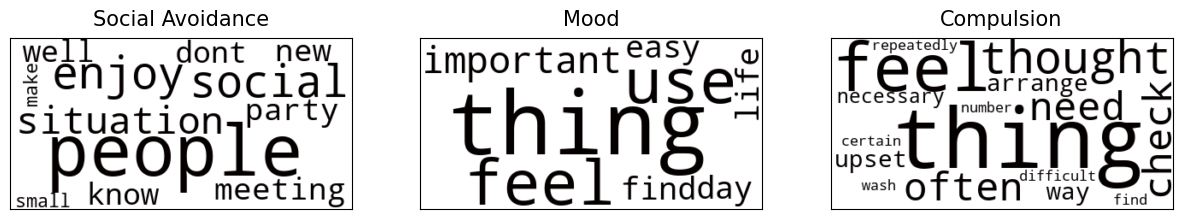

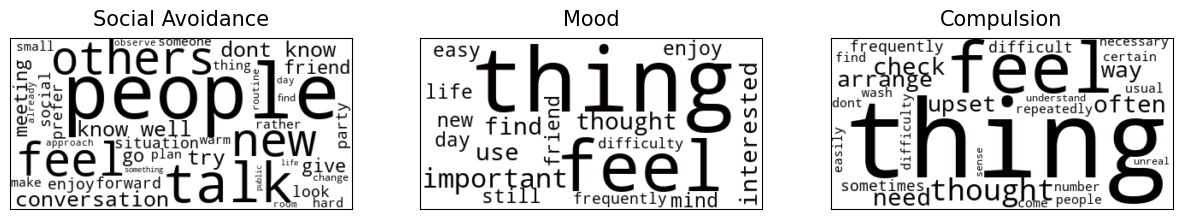

In [14]:
mask_dict = {'Top items':mask_top_items, 'Loading value':mask_value}

for mask_name, mask_f in mask_dict.items():
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    # fig.suptitle('Factor wordclouds', fontsize=suptitle_fontsize, y=.8)
    wordclouds = []
    for i, f_name in enumerate(['Social Avoidance', 'Mood', 'Compulsion']):

        # preprocess text
        factor = factor_loadings[[f_name, 'text']]
        factor = factor.sort_values(by=f_name, ascending=False)
        mask   = mask_f(factor[f_name])
        factor_items = list(factor[mask]['text'].values)
        factor_text  = preprocess_text(' '.join(factor_items)) # join into single string, then preprocess text

        # generate wordcloud
        wordcloud = WordCloud(background_color="white").generate(factor_text) #  width=3000, height=2000
        wordclouds.append(wordcloud)

        # top 10 words
        top_words = list(wordcloud.words_.keys())
        # print(f'{f_name} factor top words: {top_words[:20]}')

        # plot wordcloud
        ax = plot_wordcloud(wordcloud, ax=axs[i])
        ax.set_title(f'{f_name}', fontsize=title_fontsize, y=1.025)

    # save_figure(fig, f'EFA_wordcloud_{mask_name}', fig_dir=fig_dir)
    plt.show()

## Plot item-item correlation matrix

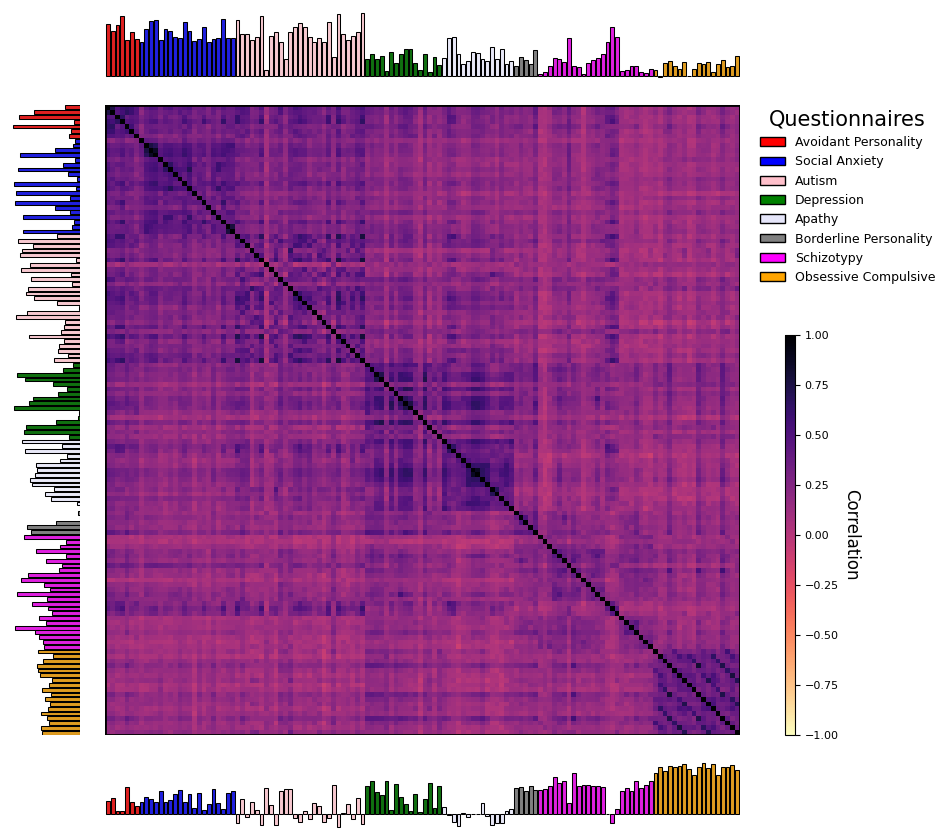

In [ ]:
def plot_factor_analysis_corrmat(corrmat, loadings=None, 
                                 factor_labels=None, outline_ques=False,
                                 corr_cmap='magma_r'):

    items = corrmat.columns
    item_dict, legend_dict = get_item_colors_and_labels(items)
    item_colors = list(item_dict.values())

    if loadings is not None:
        fig, axs = plt.subplots(3, 3, figsize=(10, 10), 
                                gridspec_kw={'hspace': 0, 'wspace': 0, 
                                             'width_ratios': [1, 9, 1], 'height_ratios': [1, 9, 1]})
        # fig.suptitle('Self-report correlation matrix and factor analysis', fontsize=title_fontsize, y=1.0)
        for ax in axs.flat: ax.axis("off")
        corr_ax   = axs[1, 1]
        legend_ax = axs[1, 2]
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        corr_ax, legend_ax, axs = ax, ax, ax
        ax.axis("off")

    #---------------------------------------------
    # plot corrmat
    #---------------------------------------------

    corr_ax = plot_corrmat(corrmat, cmap=corr_cmap, ax=corr_ax)
    add_corr_cbar(fig, corr_ax)

    if outline_ques:
        # outline each block of items in item_dict wth the corresponding color
        prefixes = {item.split('_')[0] for item in item_dict.keys()}
        for prefix in prefixes:
            indices = [i for i, item in enumerate(item_dict.keys()) if item.startswith(prefix)]
            items   = [item for item in item_dict.keys() if item.startswith(prefix)]
            color   = item_dict[items[0]]
            ax.add_patch(Rectangle((indices[0]-.25, indices[0]-.25), len(indices), len(indices),
                                    fill=False, facecolor=color, edgecolor=color, lw=2))

    #---------------------------------------------
    # questionnaire legend
    #---------------------------------------------

    patches = [mpatches.Patch(facecolor=color, edgecolor='black', label=label) for label, color in legend_dict.items()]
    legend_ax.legend(title='Questionnaires', title_fontsize=title_fontsize,
              handles=patches, frameon=False, prop={'size': 9},
              bbox_to_anchor=(2.85, 1), borderaxespad=0)

    #---------------------------------------------
    # plot loadings [optional]
    #---------------------------------------------

    if loadings is not None:

        plot_loadings_on_ax(loadings[:, 0], item_colors=item_colors, ax=axs[0, 1], orient='v', which_side='top')
        plot_loadings_on_ax(loadings[:, 1], item_colors=item_colors, ax=axs[1, 0], orient='h', which_side='left')
        plot_loadings_on_ax(loadings[:, 2], item_colors=item_colors, ax=axs[2, 1], orient='v', which_side='bottom')
    
    if factor_labels is not None:
        axs[0, 1].text(0.5, 1.15, f'Factor 1: {factor_labels[0]}', fontsize=label_fontsize, ha='center', va='bottom', 
                        transform=axs[0, 1].transAxes)
        axs[1, 0].text(-0.15, 0.5, f'Factor 2: {factor_labels[1]}', fontsize=label_fontsize, ha='center', va='center', 
                        transform=axs[1, 0].transAxes, rotation=90)
        axs[2, 1].text(0.5, -0.15, f'Factor 3: {factor_labels[2]}', fontsize=label_fontsize, ha='center', va='top', 
                        transform=axs[2, 1].transAxes)

    # plt.show()
    return fig, axs

def add_corr_cbar(fig, ax):

    cax  = fig.add_axes([.875, 0.18, 0.01, 0.4])
    cbar = fig.colorbar(ax.collections[0], cax=cax, orientation='vertical')
    cbar.ax.tick_params(labelsize=8)
    cbar.ax.set_ylabel('Correlation', fontsize=12, rotation=270, labelpad=15)

corrmat  = init_corrmat_min
loadings = init_fa_min.loadings
f_labels = ['Social Avoidance', 'Mood', 'Compulsion']
corrmat, loadings = reorder_corrmat_and_loadings(corrmat, loadings, ques_order=['apdis', 'lsas', 'bapq', 'sds', 'aes', 'zbpd', 'sss', 'oci'])
fa_fig, fa_axs    = plot_factor_analysis_corrmat(corrmat, loadings, factor_labels=None, corr_cmap="magma_r")

# add_subfig_letter(fa_axs[0,0], 'A', y=1.5)
# save_figure(fa_fig, f'{fig_dir}/EFA_corr-matrix')

NameError: name 'plot_wordcloud' is not defined

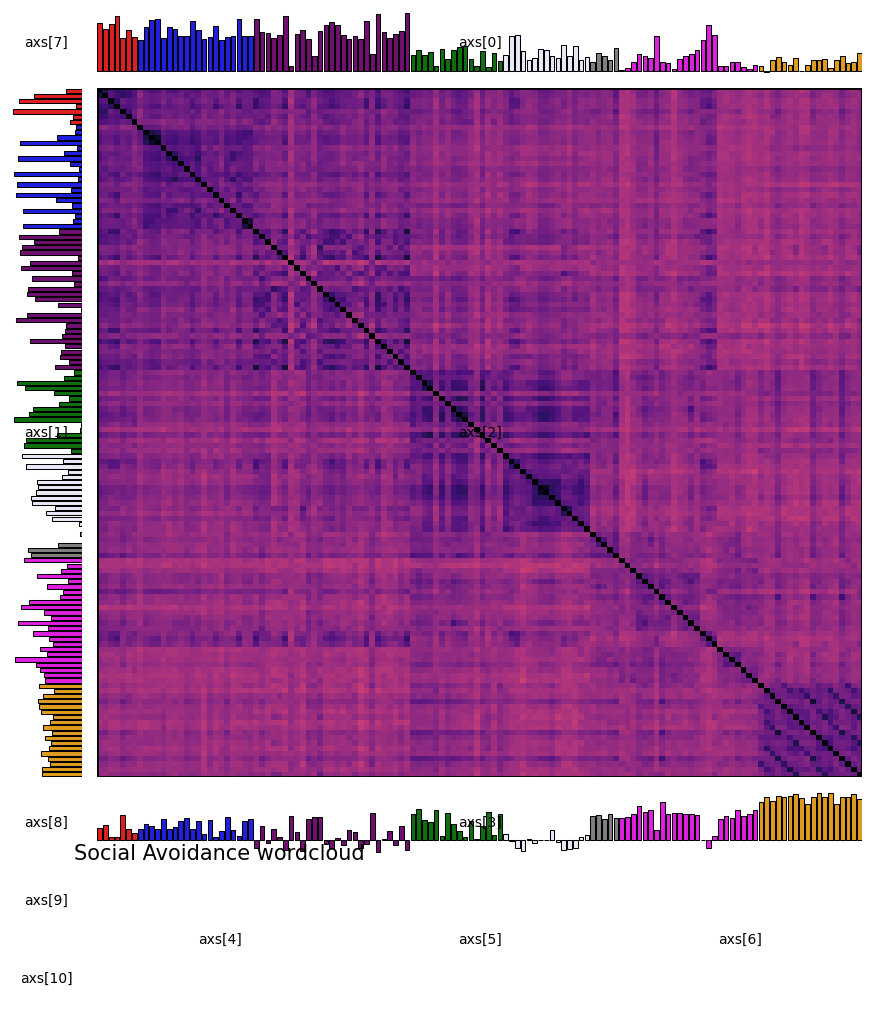

In [ ]:
s = 9
wc_s = int(s/3)
fig, axs = create_subplots((s+4, s+1), 
                      {(0, 1): (1, s), # top row
                       (1, 0): (s, 1), # leftmost column
                    #    (1, s+1): (s, 1), # rightmost column
                       (1, 1): (s, s), # main plot
                       (s+1, 1): (1, s), # bottom left
                       (s+2, 1): (wc_s, wc_s), (s+2, 1+(1*wc_s)): (wc_s, wc_s), (s+2, 1+(2*wc_s)): (wc_s, wc_s)}, # bottom row
                       figsize=(s+2, s+4), annotate=True)
for ax in axs: ax.axis('off')

ax = axs[2]
ax = plot_corrmat(corrmat, ax=ax, cmap='magma_r')
# cax = fig.add_axes([1, 0.235, 
#                     0.01, 0.4])
# cbar = fig.colorbar(ax.collections[0], cax=cax, orientation='vertical')
# cbar.ax.tick_params(labelsize=8)
# cbar.ax.set_ylabel('Correlation', fontsize=12, rotation=270, labelpad=15)

ax = axs[2]
# patches = [mpatches.Patch(facecolor=inst[0], edgecolor='black', label=inst[1]) for inst in zip(colors, legend_labels)]
# ax.legend(title='Questionnaires', title_fontsize=title_fontsize,
#             handles=patches, frameon=False, prop={'size': 9},
#             bbox_to_anchor=(1, 1), borderaxespad=0)


# get colors for items etc..
colors = ['red', 'blue', 'purple', 'green', 'lavender', 'grey', 'fuchsia', 'orange', 'dodgerblue', 
            'yellow', 'orchid', 'indigo', 'aqua', 'palegreen', 'silver', 'plum', 'fuchsia', 'coral',
            'gold', 'pink','slategray', 'forestgreen', 'peachpuff', 'honeydew', 'brown', 'olivedrab',
            'darkturquoise', 'tan', 'springgreen', 'mintcream', 'navajowhite', 'chocolate', 'lightblue', 'chartreuse',
            'lime', 'yellowgreen', 'khaki', 'gold', 'teal', 'tomato']
items         = corrmat.columns
ques_order    = np.array(list(dict.fromkeys([i.split('_')[0] for i in items])))
legend_labels = [ques_labels[q] for q in ques_order]

# for each itme, find which ques_order it matches and assign it the corresponding color
item_colors = []
for it in items:
    item_colors.extend(colors[np.where(ques_order == qo)[0][0]] for qo in ques_order if qo in it)
item_colors = list(color_converter(item_colors)['rgb'].values)

# factor loadings
factor_names = ['Social Avoidance', 'Mood', 'Compulsion']
ax = axs[0]
# ax.text(1, 1.25, f'Factor 1: {factor_names[0]}', fontsize=label_fontsize, ha='center', va='bottom', transform=ax.transAxes)
plot_loadings_on_ax(loadings[:, 0], item_colors=item_colors, ax=ax, orient='v', which_side='top', adjust=0)

ax = axs[1]
# ax.text(-0.15, 0.5, f'Factor 2: {factor_names[1]}', fontsize=label_fontsize, ha='center', va='center', rotation=90)
plot_loadings_on_ax(loadings[:, 1], item_colors=item_colors, ax=ax, orient='h', which_side='left', adjust=0)

ax = axs[3]
# ax.text(0.5, -0.15, f'Factor 3: {factor_names[2]}', fontsize=label_fontsize, ha='center', va='top', transform=ax.transAxes)
plot_loadings_on_ax(loadings[:, 2], item_colors=item_colors, ax=ax, orient='v', which_side='bottom' , adjust=0)

# wordcloudss
for i, a in enumerate([4,5,6]):
    ax = axs[a]
    ax.set_title(f'{factor_names[i]} wordcloud', fontsize=title_fontsize)
    ax = plot_wordcloud(wordclouds[i], ax=ax)
plt.tight_layout()